In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [1]:
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

In [2]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [19]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."
    
@tool
def get_news(topic: str):
    """Call to get the latest news.
    
    Args:
        topic (str): The topic to get news about.
        eg: "sports", "politics", etc.
    Returns:
        str: The latest news on the topic.
    """
    if topic.lower() in ["sports"]:
        return "The local team won the championship!"
    else:
        return "No news available on that topic."
    


In [20]:
tools = [get_weather, get_news]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [21]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [22]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'get_weather': StructuredTool(name='get_weather', description='Call to get the current weather.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x794af2ac45e0>), 'get_news': StructuredTool(name='get_news', description='Call to get the latest news.\n\n    Args:\n        topic (str): The topic to get news about.\n        eg: "sports", "politics", etc.\n    Returns:\n        str: The latest news on the topic.', args_schema=<class 'langchain_core.utils.pydantic.get_news'>, func=<function get_news at 0x794af2ac6a20>)}, tool_to_state_args={'get_weather': {}, 'get_news': {}}, tool_to_store_arg={'get_weather': None, 'get_news': None}, handle_tool_errors=True, messages_key='messages')

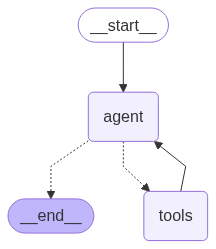

In [23]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=MemorySaver())
graph

In [24]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich? Who won the last sports championship?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich? Who won the last sports championship?', additional_kwargs={}, response_metadata={}, id='25b1e07d-2b85-491f-88bb-c31c9620a8c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KBfpXKb1i0P0bkrQMFoXbArS', 'function': {'arguments': '{"location": "Munich"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_8fMBnSA7wri0ZsPe73uBVKRl', 'function': {'arguments': '{"topic": "sports"}', 'name': 'get_news'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 115, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BdlQ8j5WlYh73vTuhIMLH7t8UuIsD', 'service_tier': 'default'

In [11]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city then?")
        ]
    },
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='What would you recommend to do in that city then?', additional_kwargs={}, response_metadata={}, id='ed42a00b-4c05-4330-8d27-073fd293de91'),
  AIMessage(content='Could you please specify which city you are referring to?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 55, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdlMUOWP4iGN9UpuXUp7qeVTYn3Qb', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1401c069-f3a0-4547-8a12-919410cbce43-0', usage_metadata={'input_tokens': 55, 'output_tokens': 12, 'total_tokens': 67, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detail

### Getting production ready - async and streaming

In [25]:
model = ChatOpenAI(model="gpt-4o-mini", streaming=True).bind_tools(tools)

In [26]:
async def call_model(state: MessagesState):
    messages = state["messages"]
    response = await model.ainvoke(messages)
    return {"messages": [response]}

In [27]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", END: END},
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=MemorySaver())

In [28]:
inputs = {"messages": [HumanMessage(content="How is the weather in Munich?")]}
config = {"configurable": {"thread_id": 2}}

In [29]:
await graph.ainvoke(input=inputs, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='0718003d-5e28-4903-9e11-af0a6bdf0920'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZJyfZD4mgJVf0q5G2LfL03VX', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'service_tier': 'default'}, id='run--2301188b-71df-4ee0-8bda-b954b42bc27e-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_ZJyfZD4mgJVf0q5G2LfL03VX', 'type': 'tool_call'}]),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='34696f21-96da-4673-a8d9-45bccc3c2fec', tool_call_id='call_ZJyfZD4mgJVf0q5G2LfL03VX'),
  AIMessage(content='The weather in Munich is currently 15 degrees Celsius and cloudy.', additional_kwargs={}, response_metadat

In [31]:
inputs = {"messages": [HumanMessage(content="How is the weather in Munich?")]}
async for output in graph.astream(inputs, stream_mode="updates", config=config):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1].pretty_print())

Output from node 'agent':
---
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_AEZs3r2aaRXzQc1UJACHJsre)
 Call ID: call_AEZs3r2aaRXzQc1UJACHJsre
  Args:
    location: Munich
None
Output from node 'tools':
---
================================= Tool Message =================================
Name: get_weather

It's 15 degrees Celsius and cloudy.
None
Output from node 'agent':
---
================================== Ai Message ==================================

The weather in Munich is currently 15 degrees Celsius and cloudy.
None


In [32]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="How is the weather in Munich?")]
gathered = None

async for msg, metadata in graph.astream(
    {"messages": inputs}, stream_mode="messages", config=config
):
    if msg.content and not isinstance(msg, HumanMessage):
        # Print each token as it streams in
        print(msg.content, end="|", flush=True)

    # Handle the AI message chunks for proper assembly
    if isinstance(msg, AIMessageChunk):
        if gathered is None:
            gathered = msg
        else:
            gathered = gathered + msg

It's 15 degrees Celsius and cloudy.|The| weather| in| Munich| is| currently| |15| degrees| Celsius| and| cloudy|.|

In [33]:
print(gathered.content)

The weather in Munich is currently 15 degrees Celsius and cloudy.
